# TME 2 : Explication par génération d'exemples contre-factuels divers
### Bouchouchi Nour (28600211)
### Borchani Sofia (21212080)

In [1]:
!pip install -U --user dice-ml 

In [2]:
import dice_ml
from dice_ml.utils import helpers # helper functions
from sklearn import datasets, svm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.metrics import accuracy_score

/home/ubuntu/.local/lib/python3.10/site-packages/dice_ml/utils/exception.py:12: UserWarning: UserConfigValidationException will be deprecated from dice_ml.utils. Please import UserConfigValidationException from raiutils.exceptions.
  warnings.warn("UserConfigValidationException will be deprecated from dice_ml.utils. "
2023-10-02 15:58:31.016472: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-02 15:58:31.017970: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-02 15:58:31.048167: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-02 15:58:31.048864: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimiz

## Données half_moons (2D)

Nous avons généré et affiché des bases de données de type halfMoons pour un niveau de bruit de 0.2. Pour l'instant on ne s'intéresse donc qu'à des données en deux dimensions. 

### Données

In [3]:
np.random.seed(42)
X,y = datasets.make_moons(n_samples=1000, shuffle=True, noise=0.2, random_state=None)

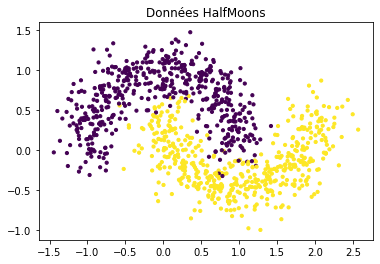

In [4]:
plt.figure()
plt.scatter(X[:,0], X[:,1], c=y, s=10)
plt.title('Données HalfMoons')
plt.show()

In [5]:
df = pd.DataFrame({'x1': X[:, 0], 'x2': X[:, 1], 'y': y})
print(df.head())
print("\nshape : ",df.shape)

         x1        x2  y
0 -0.111667  0.520224  1
1  1.142650 -0.342577  1
2  0.795558 -0.011442  1
3  0.111827 -0.551932  1
4 -0.816466  0.543996  0

shape :  (1000, 3)


In [6]:
data_train, data_test, _, _ = train_test_split(df, df["y"], test_size=0.2, random_state=42)

In [7]:
print(data_train)

           x1        x2  y
29   2.139658  0.373148  1
535 -1.206655  0.416898  0
695 -0.211713  1.171539  0
557 -0.063198  0.984219  0
836  0.393806 -0.162037  1
..        ...       ... ..
106 -0.013199  0.215043  1
270 -1.024578 -0.150359  0
860 -0.869905  0.485578  0
435  1.146308  0.194163  0
102  1.941431  0.149492  1

[800 rows x 3 columns]


In [8]:
features= ['x1','x2']
outcome = 'y'
data = dice_ml.Data(dataframe=data_train,continuous_features=features, outcome_name=outcome )

### Classifieurs

On utilise tensorflow pour apprendre notre modèle. Le but est d'apprendre à classifier les données en demi-lune de façon binaire. La frontière de séparation étant complexe nous avons créé un réseau de neurone comportant quatre couches entièrement connectées. Nous avons utilisé les fonctions d'activation ReLU, tanh, ELU et sigmoïd. L'optimiseur utilisé est Adam avec une fonction de perte de binary_crossentropy pour mesurer la performance du modèle en termes d'exactitude.

In [9]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(data_train.drop(columns="y"))
x_test_scaled = scaler.transform(data_test.drop(columns="y"))


In [10]:
clf = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(2,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='tanh'),
    tf.keras.layers.Dense(16, activation='elu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

clf.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [11]:
trained_classifieur = clf.fit(data_train.drop(columns="y"), data_train["y"], epochs=50, batch_size=16, validation_split=0.1)
model = dice_ml.Model(model=clf, backend="TF1")

Epoch 1/50
45/45 [==============================] - 1s 4ms/step - loss: 0.4802 - accuracy: 0.7986 - val_loss: 0.3248 - val_accuracy: 0.8625
Epoch 2/50
45/45 [==============================] - 0s 2ms/step - loss: 0.3105 - accuracy: 0.8569 - val_loss: 0.2630 - val_accuracy: 0.8750
Epoch 3/50
45/45 [==============================] - 0s 1ms/step - loss: 0.2845 - accuracy: 0.8736 - val_loss: 0.2447 - val_accuracy: 0.8875
Epoch 4/50
45/45 [==============================] - 0s 2ms/step - loss: 0.2680 - accuracy: 0.8778 - val_loss: 0.2272 - val_accuracy: 0.8875
Epoch 5/50
45/45 [==============================] - 0s 1ms/step - loss: 0.2576 - accuracy: 0.8833 - val_loss: 0.2177 - val_accuracy: 0.8875
Epoch 6/50
45/45 [==============================] - 0s 1ms/step - loss: 0.2427 - accuracy: 0.8944 - val_loss: 0.2005 - val_accuracy: 0.9125
Epoch 7/50
45/45 [==============================] - 0s 2ms/step - loss: 0.2266 - accuracy: 0.9042 - val_loss: 0.1854 - val_accuracy: 0.9375
Epoch 8/50
45/45 [==

### Génération d'ensembles contre-factuels

Pour notre premier exemple, nous avons paramétré notre générateur d'exemples contrefactuels de façon à obtenir 5 exemples de classe opposée pour lesquels toutes les dimensions peuvent changer et avec une importance de la proximité à l'exemple initial modérée (0.5) et une diversité au sein des contrefactuels peu importante (0.3).

In [12]:
explainer = dice_ml.Dice(data, model)
query_instance = data_test.drop(columns="y")[0:1]
print(query_instance)

counterfactuals = explainer.generate_counterfactuals(
                    query_instance,
                    total_CFs=5,
                    desired_class="opposite",
                    proximity_weight=0.5,
                    diversity_weight=0.3,
                    features_to_vary="all",
                    permitted_range=None,
                    posthoc_sparsity_param=0.1 )

           x1        x2
521  0.624776 -0.454889


100%|██████████| 1/1 [00:00<00:00,  2.62it/s]


### Récupération des exemples contrefactuels générés

Voici les contrefactuels obtenus par rapport au premier point de notre dataframe. On remarque qu'ils sont bien tous de la classe opposée. 

In [13]:
counterfactuals.visualize_as_dataframe()

Query instance (original outcome : 1)


,x1,x2,y
0,0.624776,-0.454889,1



Diverse Counterfactual set (new outcome: 0.0)


,x1,x2,y
0,-0.784798,-0.834840,0
1,-0.039296,0.887676,0
2,0.624776,0.111378,0
3,0.624776,0.494033,0
4,-1.290702,-0.454889,0


### Visulaisation et expérimentations

Dans cette partie nous allons visualiser la frontière de décision, la requête et l'ensemble des contrefactuels générés. 

In [14]:
def affiche_frontiere2D(f,X_train): 
   """    
   Affiche la frontière de décision d'une classifieur
   f : classifieur binaire
   X_train : les données d'apprentissage  
   """

   # Génération d'une grille
   x_min, x_max = X_train.iloc[:, 0].min() - 0.5, X_train.iloc[:, 0].max() + 0.5
   y_min, y_max = X_train.iloc[:, 1].min() - 0.5, X_train.iloc[:, 1].max() + 0.5
   xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

   # Prédiction chaque point de la grille
   Y = f.predict(np.c_[xx.ravel(), yy.ravel()])
   Y = Y.reshape(xx.shape)

   # Affichage de la frontière de décision
   plt.contourf(xx, yy, Y, cmap=plt.cm.coolwarm, alpha=0.5)

7/7 [==============================] - 0s 1ms/step


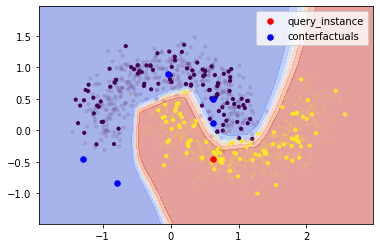

In [15]:
def visualise(clf, data_train, data_test, x, counterfactuals):

    plt.figure()
    
    affiche_frontiere2D(clf, data_train)
    y = np.where(clf.predict(data_test.drop(columns="y"))>0.5, 1, 0)
    plt.scatter(data_test["x1"],data_test["x2"], c=y, s=10)
    plt.scatter(data_train["x1"],data_train["x2"], c=data_train["y"], alpha=0.1, s=10) 

    red = plt.scatter(x["x1"],x['x2'], s=30, c='r')

    for i in range(counterfactuals.shape[0]):
        blue = plt.scatter(counterfactuals.iloc[i]["x1"],counterfactuals.iloc[i]['x2'],c='b' ,s=30)


    plt.legend([red, blue], ["query_instance","conterfactuals" ])

    plt.show()

visualise(clf, data_train, data_test, query_instance, counterfactuals.cf_examples_list[0].final_cfs_df)

On affiche ici les données de train en transparence et celles de test de façon plus opaques. Pour les données de train les classes correspondent aux classes réelles et pour les données de test les classes correspondent aux classes prédites par notre classifieur.

#### Validité

On cherche maintenant à vérifier la validité de nos contrefactuels. Nous restons dans le cadre de nos données half_moons mais cette fois nous augmentons fortement l'importance accordée à la proximité (proximity_weight=1) ce qui fait que les points générés seront possiblement plus proche de la frontière de décision. Il est donc intéressant de chercher à savoir si, malgré cela, les contrefactuels sont tout de même de classe opposée à la classe de notre query_instance. 

In [16]:
explainer = dice_ml.Dice(data, model)

counterfactuals_2= explainer.generate_counterfactuals(
                    query_instance,
                    total_CFs=10,
                    proximity_weight=15,
                    diversity_weight=0)

100%|██████████| 1/1 [00:00<00:00,  2.74it/s]


In [17]:
counterfactuals_2.visualize_as_dataframe()

Query instance (original outcome : 1)


,x1,x2,y
0,0.624776,-0.454889,1



Diverse Counterfactual set (new outcome: 0.0)


,x1,x2,y
0,-0.684410,-0.454889,0
1,-0.522032,0.155335,0
2,-0.596050,-0.454889,0
3,-0.434440,-0.770976,0
4,-1.397691,-0.454889,0
5,0.624776,0.710438,0
6,0.889975,1.243892,0
7,0.624776,0.722523,0
8,-0.667603,-0.454889,0
9,-0.612048,-0.454889,0


   1/5342 [..............................] - ETA: 1:25

7/7 [==============================] - 0s 938us/step


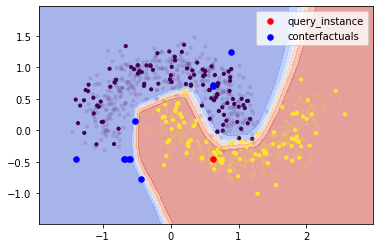

In [18]:
visualise(clf, data_train, data_test, query_instance, counterfactuals_2.cf_examples_list[0].final_cfs_df)

In [19]:
def validity(clf, x, counterfactuals):
    yhat = np.where(clf.predict(counterfactuals)>0.5, 1, 0)
    y = np.where(clf.predict(x)>0.5, 1, 0)
    print("Validité : "+ str(np.mean(yhat!=y)*100) + "%")

validity(clf, query_instance,counterfactuals_2.cf_examples_list[0].final_cfs_df.drop(columns="y"))


1/1 [==============================] - 0s 14ms/step
Validité : 100.0%


Malgré le fait que l'on cherche à avoir une forte proximité entre le point à expliquer et les exemples contrefactuels générés, on remarque que tous les exemples obtenus sont bien de la classe opposée (100%). 

Par la suite, nous allons nous pencher plus amplement sur la proximité et la parcimonie des exemples générés. En effet, tous les scénarios contrefactuels ne sont pas réalisables pour un utilisateur donné. Généralement, les contrefactuels qui sont plus proches du profil individuel de l'utilisateur seront plus praticables d'où l'intérêt d'avoir un poids associé à la proximité qui soit élevé. Il est également essentiel d'avoir une diversité d'options pour aider un individu à choisir parmi plusieurs possibilités. 



#### Proximité

In [20]:
def proximity(x, counterfactuals):
    dist = []
    for i in range(counterfactuals.shape[0]):
        dist.append(np.linalg.norm(counterfactuals.iloc[i].values - x.values.flatten()))
    moy = np.mean(dist)
    var = np.std(dist)
    print("Distance moyenne des contre-factuels à x : ", moy)
    print("L'écart type de la distance des contre-factuels à x : ", var)

proximity(query_instance,counterfactuals_2.cf_examples_list[0].final_cfs_df.drop(columns="y"))


Distance moyenne des contre-factuels à x :  1.3548205149693655
L'écart type de la distance des contre-factuels à x :  0.273717531630685


#### Parcimonie

In [21]:
def sparcity(x, counterfactuals, plot = True):
    
    nb_dimensions_differentes=[]
    
    for i in range(counterfactuals.shape[0]):
        
        nb_dim_diff = np.count_nonzero(x.values != counterfactuals.iloc[i].values)
        nb_dimensions_differentes.append(nb_dim_diff)
    
    if plot == True :
        plt.hist(nb_dimensions_differentes, bins=range(max(nb_dimensions_differentes)+2), align = 'left', rwidth=0.5 )
        plt.xticks(range(max(nb_dimensions_differentes)+2))
        plt.xlabel('Nombre d\' attributs modifiées')
        plt.ylabel('Nombre d\'éléments')
        plt.title("Histogramme du nombre d'attributs différents entre x et e*")
        plt.grid(True)
        plt.show()
    print("Nombre moyen d'attributs modifiés : ", np.mean(nb_dimensions_differentes))
    print("Ecart type du nombre d'attributs modifiés : ",  np.std(nb_dimensions_differentes))

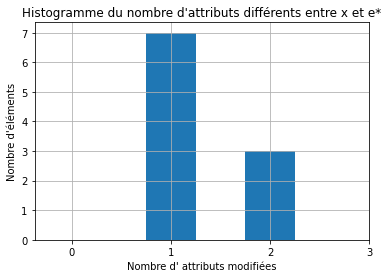

Nombre moyen d'attributs modifiés :  1.3
Ecart type du nombre d'attributs modifiés :  0.45825756949558394


In [22]:
sparcity(query_instance,counterfactuals_2.cf_examples_list[0].final_cfs_df.drop(columns="y"))

### Variation d'un unique paramètre

Dans un cadre applicatif, certaines caractéristiques peuvent être plus difficile à modifier que d'autres tels que l'âge ou la situation maritale, par conséquent nous ne voulons pas d'explications entraînant la modification d'un tel paramètre. Dans notre exemple test avec des données en deux dimensions, nous allons nous intéresser au cas où l'on ne souhaiterait pas modifier le paramètre x2. 

100%|██████████| 1/1 [00:00<00:00,  4.77it/s]

 310/5342 [>.............................] - ETA: 2s

7/7 [==============================] - 0s 847us/step


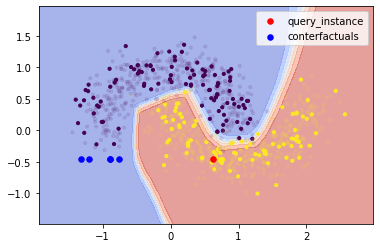

In [23]:
query_instance = data_test.drop(columns="y")[:1]
counterfactuals = explainer.generate_counterfactuals(
                    query_instance,
                    total_CFs=5,
                    desired_class="opposite",
                    features_to_vary=["x1"])
visualise(clf, data_train, data_test, query_instance, counterfactuals.cf_examples_list[0].final_cfs_df)

In [24]:
validity(clf, query_instance,counterfactuals.cf_examples_list[0].final_cfs_df.drop(columns="y"))

1/1 [==============================] - 0s 14ms/step
Validité : 100.0%


In [25]:
proximity(query_instance,counterfactuals.cf_examples_list[0].final_cfs_df.drop(columns="y"))

Distance moyenne des contre-factuels à x :  1.6377958307252818
L'écart type de la distance des contre-factuels à x :  0.2077010008021394


In [26]:
sparcity(query_instance,counterfactuals.cf_examples_list[0].final_cfs_df.drop(columns="y"), plot=False)

Nombre moyen d'attributs modifiés :  1.0
Ecart type du nombre d'attributs modifiés :  0.0


On observe ici, que la validité et la proximité n'ont pas été impactés par le choix de ne faire varier qu'un attribut. On note, comme l'on s'y attendait, que le nombre d'attributs modifiés est désormais toujours égal à 1. 

### Poids sur les attributs

On peut également décider que certains attributs sont plus coûteux à modifier que d'autres. On peut alors attribuer des poids différents à chaque dimension. Selon la documention de DiCE une fonctionnalité permet de réaliser ceci : feature_weights. Néanmoins, il semblerait que cette fonctionnalité ne soit plus permise par DiCE. 

In [27]:
#query_instance = data_test.drop(columns="y")[:1]

#feature_weights = {'x1': 10, 'x2': 1}
#counterfactuals = explainer.generate_counterfactuals(
#                    query_instance,
#                    total_CFs=5,
#                    desired_class="opposite",
#                    feature_weights=feature_weights)

#visualise(clf, data_train, data_test, query_instance, counterfactuals.cf_examples_list[0].final_cfs_df)

### Jeux de données classiques

Désormais, nous allons nous intéresser à un jeu de donnée de dimension supérieure à 2 : income. Il s'agit d'un dataset pour lequel sont renseigné l'âge, le secteur de travail,le diplôme, le statut marital, la profession, l'origine ethnique, le genre et le nombre d'heure travaillées par semaine dans le but de prédire le salaire. 

### Dataset income

In [28]:
from dice_ml.utils import helpers 

dataset = helpers.load_adult_income_dataset()
target = dataset["income"] 
train_dataset, test_dataset, _, _ = train_test_split(dataset,
                                                     target,
                                                     test_size=0.2,
                                                     random_state=0,
                                                     stratify=target)

In [29]:
d = dice_ml.Data(dataframe=train_dataset,
                 continuous_features=['age','hours_per_week'],
                 outcome_name='income')

In [30]:
m = dice_ml.Model(model_path=dice_ml.utils.helpers.get_adult_income_modelpath(),
                  backend='TF2', func="ohe-min-max")

In [31]:
exp = dice_ml.Dice(d,m)

In [32]:
query_instance = test_dataset.drop(columns="income")[0:1]
dice_exp = exp.generate_counterfactuals(query_instance,
                                         total_CFs=10, 
                                         desired_class="opposite")
dice_exp.visualize_as_dataframe()

100%|██████████| 1/1 [00:00<00:00,  1.52it/s]

Query instance (original outcome : 0)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,29,Private,HS-grad,Married,Blue-Collar,White,Female,38,0



Diverse Counterfactual set (new outcome: 1.0)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,29,Government,Masters,Married,Blue-Collar,White,Female,38,1
1,29,Self-Employed,HS-grad,Married,Blue-Collar,White,Female,76.0,1
2,72.0,Private,Assoc,Married,Blue-Collar,White,Female,38,1
3,29,Private,HS-grad,Married,Professional,White,Female,84.0,1
4,29,Private,Prof-school,Married,Service,White,Female,38,1
5,29,Private,HS-grad,Married,Blue-Collar,White,Female,69.0,1
6,29,Government,Doctorate,Married,Blue-Collar,White,Female,38,1
7,29,Self-Employed,HS-grad,Married,Blue-Collar,White,Female,54.0,1
8,29,Other/Unknown,Masters,Married,Blue-Collar,White,Female,38,1
9,39.0,Private,Masters,Married,Blue-Collar,White,Female,38,1


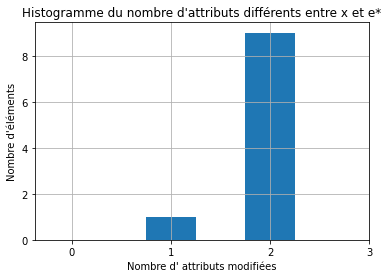

Nombre moyen d'attributs modifiés :  1.9
Ecart type du nombre d'attributs modifiés :  0.3


In [33]:
sparcity(query_instance, dice_exp.cf_examples_list[0].final_cfs_df.drop(columns='income'))

Ici, on note qu'un à deux attributs modifiés suffisent à expliquer l'exemple. Il peut néanmoins être intérerssant de regarder quels sont les attributs les plus modifiés. 

In [34]:
def which_attribute(x, counterfactuals, y_labels):
    
    att = np.zeros(len(y_labels))
    for i in range(counterfactuals.shape[0]):
        _,att_diff = np.where(x.values != counterfactuals.iloc[i].values)
        for j in att_diff : 
            att[j]+=1
        
    angles = np.linspace(0, 2*np.pi, len(y_labels), endpoint=False)
    fig = plt.figure()
    ax = fig.add_subplot(111, polar=True)
    ax.plot(angles, att, 'o-', linewidth=2)
    ax.fill(angles, att, alpha=0.25)
    ax.set_thetagrids(angles * 180/np.pi, y_labels)
    ax.set_title("Attribut modifié")
    ax.grid(True)
    plt.show()
    





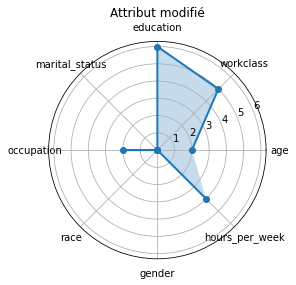

In [35]:
labels = ['age', 'workclass', 'education', 'marital_status', 'occupation', 'race', 'gender', 'hours_per_week']
which_attribute(query_instance, dice_exp.cf_examples_list[0].final_cfs_df.drop(columns='income'), labels)

Néanmoins, il est possible que certains attributs ne puissent pas être modifiés (comme l'âge, le genre, l'origine éthnique, le statut marital ou le niveau de diplôme). On peut donc décider de s'intéresser à des explications ne nécessitant pas de changer ces paramètres. 

In [36]:
query_instance = test_dataset.drop(columns="income")[0:1]
dice_exp = exp.generate_counterfactuals(query_instance, total_CFs=10, desired_class="opposite", 
                                       features_to_vary=["workclass", "occupation", "hours_per_week"])
dice_exp.visualize_as_dataframe()

100%|██████████| 1/1 [00:00<00:00,  1.54it/s]

Query instance (original outcome : 0)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,29,Private,HS-grad,Married,Blue-Collar,White,Female,38,0



Diverse Counterfactual set (new outcome: 1.0)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,29,Private,HS-grad,Married,Sales,White,Female,77.0,1
1,29,Private,HS-grad,Married,Blue-Collar,White,Female,74.0,1
2,29,Private,HS-grad,Married,Other/Unknown,White,Female,94.0,1
3,29,Private,HS-grad,Married,Sales,White,Female,56.0,1
4,29,Private,HS-grad,Married,Professional,White,Female,86.0,1
5,29,Private,HS-grad,Married,Service,White,Female,62.0,1
6,29,Self-Employed,HS-grad,Married,Blue-Collar,White,Female,76.0,1
7,29,Private,HS-grad,Married,Blue-Collar,White,Female,79.0,1
8,29,Private,HS-grad,Married,Other/Unknown,White,Female,67.0,1
9,29,Private,HS-grad,Married,Other/Unknown,White,Female,65.0,1


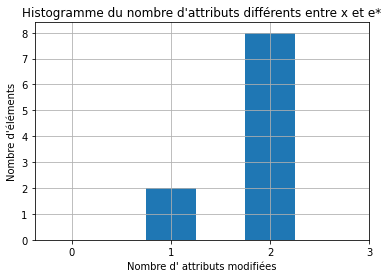

Nombre moyen d'attributs modifiés :  1.8
Ecart type du nombre d'attributs modifiés :  0.4


In [37]:
sparcity(query_instance, dice_exp.cf_examples_list[0].final_cfs_df.drop(columns='income'))

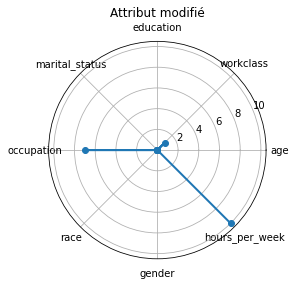

In [38]:
labels = ['age', 'workclass', 'education', 'marital_status', 'occupation', 'race', 'gender', 'hours_per_week']
which_attribute(query_instance, dice_exp.cf_examples_list[0].final_cfs_df.drop(columns='income'), labels)

# 7.Extension GS

In [39]:
# Créez un DataFrame de démonstration
data = {'Name': ['Alice', 'Bob', 'Charlie', 'David', 'Eve'],
        'Age': [25, 30, 22, 35, 28],
        'City': ['New York', 'Los Angeles', 'Chicago', 'Houston', 'Miami']}

df = pd.DataFrame(data)

# Affichez le DataFrame d'origine
print("DataFrame d'origine:")
print(df)

# Méthode 1 : Utilisation de `loc`
result_loc = df.loc[df['Age'] == 30]
print("\nRésultat avec `loc`:")
print(result_loc)

# Méthode 2 : Utilisation de l'indexation booléenne
result_bool = df[df['City'] == 'Chicago']
print("\nRésultat avec l'indexation booléenne:")
print(result_bool)

DataFrame d'origine:
      Name  Age         City
0    Alice   25     New York
1      Bob   30  Los Angeles
2  Charlie   22      Chicago
3    David   35      Houston
4      Eve   28        Miami

Résultat avec `loc`:
  Name  Age         City
1  Bob   30  Los Angeles

Résultat avec l'indexation booléenne:
      Name  Age     City
2  Charlie   22  Chicago


## Modif GS


Nous allons désormais implémenter une variante de GS permettant à l'utilisateur de spécifier des attributs non modifiables à l'instar de ce qui est proposé par DiCE. Par exemple, ci-dessous, nous allons tout d'abord supposer que l'attribut x2 n'est pas modifiable. 

In [165]:
def SL(x,a0,a1,n, att_non_modif=[]):
    """
    Génère n points dans la couche sphérique de centre x et de rayon interne a0 et de rayon externe a1
    x : centre de la sphere 
    a0 : rayon interne
    a1 : rayon externe
    n : nombre de points générés 
    """
    val_non_modif = []
    if(att_non_modif != []):
        for i in range(len(att_non_modif)) : 
            val_non_modif.append(x[att_non_modif[i]])
        x = np.delete(x, att_non_modif)  

    d = x.shape[0] #dimension des données
    z = np.random.normal(0,1,(n,d)) # on génère des points suivant une loi normale

    norms = np.linalg.norm(z, axis=1) # on calcule la norme par ligne 
    z = z / norms[:, np.newaxis] # on divise chaque ligne par sa norme 
    
    u = (np.random.uniform(a0**d,a1**d,n))**(1/d)

    res = x + z*u[:,np.newaxis] 
    if(att_non_modif != [] ):
        for i in range(len(att_non_modif)) : 
            res = np.insert(res, att_non_modif[i], val_non_modif[:][i], axis=1)
    
    return res 

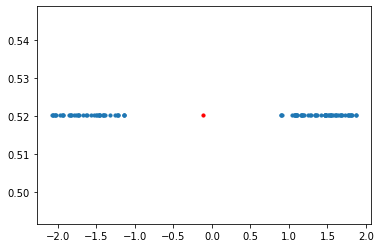

In [166]:
res =SL(X[0],1,2,100,[1])
plt.figure()
plt.scatter(res[:,0],res[:,1], s=10)
plt.scatter(X[0][0],X[0][1], s=10, c ='r')
plt.show()

In [167]:
def GS(f,x,eta,n, att_non_modif=-1):
    """
    Algorithme des growking sphere : retourne l'enemy le plus proche de x  avec la distance l2 minimale (point de classe opposé le plus proche de x)
    f : classifieur binaire
    x : observation à interpréter
    eta : épaisseur de la sphere 
    n : nombre de points générés  
    """
    z = SL(x, 0, eta, n, att_non_modif)
    predict_x = f.predict([x])

    while(not np.all(predict_x == f.predict(z))): 
        eta = eta/2
        z = SL(x,0,eta,n)

    a0 = eta
    a1 = 2*eta

    while (np.all(predict_x== f.predict(z))):
        z = SL(x,a0,a1,n, att_non_modif)
        a0 = a1
        a1 += eta

    liste_e = z[np.where(predict_x != f.predict(z))[0]] #liste des enemy
    l2 = np.sqrt( np.sum((x - liste_e)**2, axis=1) ) #distance l2 calculée pour chaque enemy


    return liste_e[np.argmin(l2)] #selection de l'enemy avec la distance l2 minimale 


In [168]:
clf = svm.SVC()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf.fit(X_train, y_train)

e = GS(clf, X[0],0.5,50, [1])
print("La classe prédite pour x " + str(X[0]) + " est " + str(clf.predict([X[0]])))
print("La classe prédite pour e " + str(e) + " est " + str(clf.predict([e])))

La classe prédite pour x [-0.11166654  0.52022374] est [1]
La classe prédite pour e [-0.18598403  0.52022374] est [0]


#### Test de GS modifié sur le dataset Wine

Nous allons tester cette fonctionnalité sur un dataset plus grand (le dataset wine). On ne veut cette fois pas modifier les deux premiers attributs à savoir l'attribut "alcohol" et "malic_acid".

In [169]:
data = datasets.load_wine()
df = pd.DataFrame(data.data, columns=data.feature_names)
X_data_train, X_data_test, y_data_train, y_data_test = train_test_split(data.data, data.target, test_size=0.2, random_state=42)

In [170]:
clf = svm.SVC()
clf.fit(X_data_train, y_data_train)
yhat = clf.predict(X_data_test)
print("accuracy : ", accuracy_score(y_data_test,yhat))

accuracy :  0.8055555555555556


In [171]:
e = GS(clf,X_data_test[:1][0],0.1,100, [0])
print("La classe prédite pour x " + str(X_data_test[:1][0]) + " est " + str(clf.predict([X_data_test[:1][0]])))
print("\nLa classe prédite pour e " + str(e) + " est " + str(clf.predict([e])))

La classe prédite pour x [1.364e+01 3.100e+00 2.560e+00 1.520e+01 1.160e+02 2.700e+00 3.030e+00
 1.700e-01 1.660e+00 5.100e+00 9.600e-01 3.360e+00 8.450e+02] est [0]

La classe prédite pour e [ 1.36400000e+01  3.17120358e+00  5.45609491e+00  1.79196509e+01
  1.10356791e+02 -5.27877030e-01  1.76872478e+00 -1.70062807e+00
  5.10698713e-01  6.55741443e+00  2.01071578e+00  1.26430886e+00
  8.33903618e+02] est [2]


In [172]:
e = GS(clf,X_data_test[:1][0],0.1,100, [0,1])
print("La classe prédite pour x " + str(X_data_test[:1][0]) + " est " + str(clf.predict([X_data_test[:1][0]])))
print("\nLa classe prédite pour e " + str(e) + " est " + str(clf.predict([e])))

La classe prédite pour x [1.364e+01 3.100e+00 2.560e+00 1.520e+01 1.160e+02 2.700e+00 3.030e+00
 1.700e-01 1.660e+00 5.100e+00 9.600e-01 3.360e+00 8.450e+02] est [0]

La classe prédite pour e [ 13.64         3.1          3.30027082  19.56588763 114.84608207
   0.99036998   4.34849591  -3.32498972   5.71542351   3.26931673
  -2.94278763   4.55994948 833.47802804] est [2]


In [173]:
def which_attribute(f, X, y_labels, att_modif):
    att = np.zeros(len(X[0]))

    for x in X :
        e = GS(f,x,0.1,100, att_modif)

        att_diff = np.where(e != x)
        att[att_diff]+=1
    
    
    angles = np.linspace(0, 2*np.pi, len(y_labels), endpoint=False)
    
    fig = plt.figure()
    ax = fig.add_subplot(111, polar=True)
    ax.plot(angles, att, 'o-', linewidth=2)
    ax.fill(angles, att, alpha=0.25)
    ax.set_thetagrids(angles * 180/np.pi, y_labels)
    ax.set_title("Attribut modifié")
    ax.grid(True)
    plt.show()

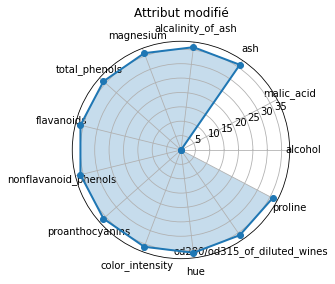

In [174]:
which_attribute(clf, X_data_test, data.feature_names, [0,1])

# Conclusion

Pour conclure, différentes approches peuvent être utilisées dans le but d'expliquer un exemple. DiCE permet d'intégrer de nombreux paramètres tels que le nombre d'exemples contre-factuels générés. Il est aussi possible d'accorder une importance plus ou moins grande à leur proximité à l'exemple à expliquer et à leurs diversité. 

Il est également possible d'implémenter certaines de ces modifications dans l'algorithme GS à l'instar des attributs à ne pas modifier. En revanche, cet algorithme s'appuie sur une heuristique qui vise à tout d'abord minimiser la distance puis à maximiser la parcimonie. Ainsi, il n'est pas possible, comme c'est le cas avec DiCE, de choisir de privilégier la diversité au sein des contrefactuels obtenus au détriment de la distance. 